<a href="https://colab.research.google.com/github/Akashsky123/Deep-Learning-Lab/blob/main/Experiment_6(seq2seq_eng_spanish).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence-to-Sequence Learning: English → Spanish Translation
### LSTM Encoder-Decoder (Without & With Attention: Bahdanau + Luong)
---

## Cell 1: Install Dependencies

In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install nltk sacrebleu matplotlib seaborn --quiet
print("All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 5.8 MB/s eta 0:00:00
All packages installed successfully!


## Cell 2: Import Libraries

In [2]:
import os
import re
import random
import unicodedata
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

nltk.download('punkt', quiet=True)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


## Cell 3: Download Dataset
We use the **Tatoeba English-Spanish** dataset from ManyThings.org — a popular, freely available parallel corpus.

In [5]:
import urllib.request
import zipfile
import os # Ensure os is imported for os.path.exists

DATA_URL  = "https://www.manythings.org/anki/spa-eng.zip"
DATA_ZIP  = "spa-eng.zip"
DATA_FILE = "spa.txt"   # file inside the zip

if not os.path.exists(DATA_FILE):
    print("Downloading dataset...")
    # Create a Request object with a more detailed User-Agent header
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    req = urllib.request.Request(DATA_URL, headers=headers)

    try:
        # Use urlopen to perform the request and then write the content to a file
        with urllib.request.urlopen(req) as response, open(DATA_ZIP, 'wb') as out_file:
            out_file.write(response.read())
        with zipfile.ZipFile(DATA_ZIP, 'r') as z:
            z.extract(DATA_FILE)
        print("Download complete!")
    except urllib.error.HTTPError as e:
        print(f"HTTP Error: {e.code} - {e.reason}")
        print("This might be due to server blocking automated requests. Trying a different method or URL might be necessary.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print("Dataset already exists.")

# Quick peek
if os.path.exists(DATA_FILE):
    with open(DATA_FILE, encoding='utf-8') as f:
        lines = f.readlines()

    print(f"Total sentence pairs: {len(lines)}")
    print("Sample lines:")
    for line in lines[:5]:
        print(" ", line.strip())
else:
    print("Dataset not found after download attempt.")

Download complete!
Total sentence pairs: 144215
Sample lines:
  Go.	Ve.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
  Go.	Vete.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
  Go.	Vaya.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
  Go.	Váyase.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
  Go.	Id.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #13703671 (Seael)


## Cell 4: Preprocessing Utilities

In [6]:
SOS_TOKEN = 0
EOS_TOKEN = 1
PAD_TOKEN = 2
MAX_LEN   = 15          # max tokens per sentence (filters long pairs)
NUM_PAIRS = 10000       # use 10k pairs for training speed

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2idx = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2}
        self.idx2word = {0: '<SOS>', 1: '<EOS>', 2: '<PAD>'}
        self.n_words   = 3

    def add_sentence(self, sentence):
        for word in sentence.split():
            self._add_word(word)

    def _add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.n_words += 1


def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s.strip()

def filter_pair(pair):
    return (
        len(pair[0].split()) < MAX_LEN and
        len(pair[1].split()) < MAX_LEN
    )

def load_data(filepath, num_pairs=NUM_PAIRS):
    with open(filepath, encoding='utf-8') as f:
        lines = f.readlines()

    pairs = []
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            eng = normalize_string(parts[0])
            spa = normalize_string(parts[1])
            pairs.append((eng, spa))

    pairs = [p for p in pairs if filter_pair(p)]
    random.shuffle(pairs)
    pairs = pairs[:num_pairs]

    src_vocab = Vocabulary('english')
    tgt_vocab = Vocabulary('spanish')
    for eng, spa in pairs:
        src_vocab.add_sentence(eng)
        tgt_vocab.add_sentence(spa)

    return pairs, src_vocab, tgt_vocab

pairs, src_vocab, tgt_vocab = load_data(DATA_FILE)
print(f"Filtered pairs : {len(pairs)}")
print(f"English vocab  : {src_vocab.n_words}")
print(f"Spanish vocab  : {tgt_vocab.n_words}")
print("\nSample pair:")
print(" ENG:", pairs[0][0])
print(" SPA:", pairs[0][1])

Filtered pairs : 10000
English vocab  : 4770
Spanish vocab  : 7399

Sample pair:
 ENG: the teacher emphasized the importance of education .
 SPA: el profesor subrayo la importancia de la educacion .


## Cell 5: Dataset & DataLoader

In [7]:
def sentence_to_tensor(vocab, sentence):
    idxs = [vocab.word2idx[w] for w in sentence.split() if w in vocab.word2idx]
    idxs.append(EOS_TOKEN)
    return torch.tensor(idxs, dtype=torch.long)

def pad_sequence_custom(sequences, pad_token=PAD_TOKEN):
    max_len = max(len(s) for s in sequences)
    padded  = torch.full((len(sequences), max_len), pad_token, dtype=torch.long)
    lengths = []
    for i, s in enumerate(sequences):
        padded[i, :len(s)] = s
        lengths.append(len(s))
    return padded, torch.tensor(lengths)

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab):
        self.data = [
            (sentence_to_tensor(src_vocab, eng),
             sentence_to_tensor(tgt_vocab, spa))
            for eng, spa in pairs
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    src_seqs, tgt_seqs = zip(*batch)
    src_padded, src_lens = pad_sequence_custom(src_seqs)
    tgt_padded, tgt_lens = pad_sequence_custom(tgt_seqs)
    return src_padded, src_lens, tgt_padded, tgt_lens

# Train / Val / Test split  (80 / 10 / 10)
n = len(pairs)
train_pairs = pairs[:int(0.8 * n)]
val_pairs   = pairs[int(0.8 * n):int(0.9 * n)]
test_pairs  = pairs[int(0.9 * n):]

BATCH_SIZE = 64

train_loader = DataLoader(TranslationDataset(train_pairs, src_vocab, tgt_vocab),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(TranslationDataset(val_pairs,   src_vocab, tgt_vocab),
                          batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(TranslationDataset(test_pairs,  src_vocab, tgt_vocab),
                          batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_pairs)} | Val: {len(val_pairs)} | Test: {len(test_pairs)}")
print(f"Train batches: {len(train_loader)}")

Train: 8000 | Val: 1000 | Test: 1000
Train batches: 125


## Cell 6: Model Architecture — Encoder

In [8]:
class Encoder(nn.Module):
    """
    Bidirectional LSTM Encoder.
    Returns:
      outputs : (batch, seq_len, hidden*2)  — all hidden states (used by attention)
      hidden  : (num_layers, batch, hidden) — last forward hidden
      cell    : (num_layers, batch, hidden) — last forward cell
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding  = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN)
        self.lstm       = nn.LSTM(embed_dim, hidden_dim, num_layers,
                                  batch_first=True, dropout=dropout if num_layers > 1 else 0,
                                  bidirectional=True)
        # Project bidirectional hidden/cell → decoder hidden size
        self.fc_h = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_c = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        # src: (batch, seq_len)
        embedded = self.embedding(src)               # (batch, seq_len, embed)
        outputs, (hidden, cell) = self.lstm(embedded)
        # hidden/cell: (num_layers*2, batch, hidden)
        # Concat forward + backward for each layer
        hidden = torch.tanh(self.fc_h(
            torch.cat([hidden[-2], hidden[-1]], dim=1)))  # (batch, hidden)
        cell   = torch.tanh(self.fc_c(
            torch.cat([cell[-2],  cell[-1]],  dim=1)))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell   = cell.unsqueeze(0).repeat(self.num_layers,  1, 1)
        return outputs, hidden, cell  # outputs: (batch, seq, hidden*2)

print("Encoder defined.")

Encoder defined.


## Cell 7: Decoder (No Attention)

In [9]:
class DecoderNoAttn(nn.Module):
    """
    Vanilla LSTM Decoder — no attention, uses only the encoder's
    final hidden & cell states as context.
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim, num_layers,
                                  batch_first=True,
                                  dropout=dropout if num_layers > 1 else 0)
        self.fc_out    = nn.Linear(hidden_dim, vocab_size)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, tgt_token, hidden, cell, encoder_outputs=None):
        # tgt_token: (batch,)  →  (batch, 1)
        tgt_token = tgt_token.unsqueeze(1)
        embedded  = self.dropout(self.embedding(tgt_token))   # (batch, 1, embed)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))           # (batch, vocab)
        return prediction, hidden, cell, None   # None for attn weights

print("Vanilla Decoder defined.")

Vanilla Decoder defined.


## Cell 8: Bahdanau (Additive) Attention Decoder

In [10]:
class BahdanauAttention(nn.Module):
    """
    score = V * tanh(W1*encoder_out + W2*decoder_hidden)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim * 2, hidden_dim)   # encoder outputs are bidirectional
        self.W2 = nn.Linear(hidden_dim,     hidden_dim)
        self.V  = nn.Linear(hidden_dim, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden : (batch, hidden)
        # encoder_outputs: (batch, src_len, hidden*2)
        dec_h = decoder_hidden.unsqueeze(1)                     # (batch, 1, hidden)
        energy = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(dec_h)))  # (batch, src, 1)
        attn   = F.softmax(energy.squeeze(2), dim=1)           # (batch, src)
        context = torch.bmm(attn.unsqueeze(1), encoder_outputs) # (batch, 1, hidden*2)
        return context, attn


class DecoderBahdanau(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.attention = BahdanauAttention(hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN)
        # input: embed + context (hidden*2)
        self.lstm      = nn.LSTM(embed_dim + hidden_dim * 2, hidden_dim, num_layers,
                                  batch_first=True,
                                  dropout=dropout if num_layers > 1 else 0)
        self.fc_out    = nn.Linear(hidden_dim + hidden_dim * 2 + embed_dim, vocab_size)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, tgt_token, hidden, cell, encoder_outputs):
        tgt_token = tgt_token.unsqueeze(1)                         # (batch,1)
        embedded  = self.dropout(self.embedding(tgt_token))        # (batch,1,embed)
        dec_h_top = hidden[-1]                                     # top-layer hidden
        context, attn = self.attention(dec_h_top, encoder_outputs) # (batch,1,hidden*2)
        rnn_input = torch.cat([embedded, context], dim=2)          # (batch,1,embed+hidden*2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        # output: (batch,1,hidden)
        combined   = torch.cat([output, context, embedded], dim=2) # (batch,1,...)
        prediction = self.fc_out(combined.squeeze(1))              # (batch, vocab)
        return prediction, hidden, cell, attn

print("Bahdanau Attention Decoder defined.")

Bahdanau Attention Decoder defined.


## Cell 9: Luong (Multiplicative) Attention Decoder

In [11]:
class LuongAttention(nn.Module):
    """
    'dot' variant: score = decoder_hidden · encoder_output
    (general): score = decoder_hidden · Wa · encoder_output
    We use the 'general' form for flexibility.
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden : (batch, hidden)
        # encoder_outputs: (batch, src_len, hidden*2)
        dec_h     = decoder_hidden.unsqueeze(2)                       # (batch,hidden,1)
        energy    = torch.bmm(self.Wa(encoder_outputs), dec_h)        # (batch,src,1)
        attn      = F.softmax(energy.squeeze(2), dim=1)               # (batch,src)
        context   = torch.bmm(attn.unsqueeze(1), encoder_outputs)     # (batch,1,hidden*2)
        return context, attn


class DecoderLuong(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.attention = LuongAttention(hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim, num_layers,
                                  batch_first=True,
                                  dropout=dropout if num_layers > 1 else 0)
        # attentional hidden: concat(decoder_out, context)
        self.concat  = nn.Linear(hidden_dim + hidden_dim * 2, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt_token, hidden, cell, encoder_outputs):
        tgt_token = tgt_token.unsqueeze(1)                          # (batch,1)
        embedded  = self.dropout(self.embedding(tgt_token))         # (batch,1,embed)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        dec_h_top = hidden[-1]                                      # top-layer
        context, attn = self.attention(dec_h_top, encoder_outputs)
        attentional = torch.tanh(
            self.concat(torch.cat([output, context], dim=2)))       # (batch,1,hidden)
        prediction  = self.fc_out(attentional.squeeze(1))           # (batch,vocab)
        return prediction, hidden, cell, attn

print("Luong Attention Decoder defined.")

Luong Attention Decoder defined.


## Cell 10: Seq2Seq Wrapper

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device  = device
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src, tgt):
        batch_size  = src.shape[0]
        tgt_len     = tgt.shape[1]
        tgt_vocab_s = self.decoder.fc_out.out_features

        outputs  = torch.zeros(batch_size, tgt_len, tgt_vocab_s).to(self.device)
        enc_out, hidden, cell = self.encoder(src)

        input_token = tgt[:, 0]   # <SOS>

        for t in range(1, tgt_len):
            pred, hidden, cell, _ = self.decoder(input_token, hidden, cell, enc_out)
            outputs[:, t] = pred
            use_teacher   = random.random() < self.teacher_forcing_ratio
            input_token   = tgt[:, t] if use_teacher else pred.argmax(dim=1)

        return outputs

print("Seq2Seq wrapper defined.")

Seq2Seq wrapper defined.


## Cell 11: Hyperparameters & Model Instantiation

In [13]:
EMBED_DIM   = 256
HIDDEN_DIM  = 512
NUM_LAYERS  = 2
DROPOUT     = 0.3
EPOCHS      = 3          # 3 epochs as specified
LEARNING_RATE = 1e-3
CLIP        = 1.0

SRC_VOCAB = src_vocab.n_words
TGT_VOCAB = tgt_vocab.n_words

def build_model(decoder_type='none'):
    enc = Encoder(SRC_VOCAB, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
    if   decoder_type == 'none':     dec = DecoderNoAttn  (TGT_VOCAB, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
    elif decoder_type == 'bahdanau': dec = DecoderBahdanau(TGT_VOCAB, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
    elif decoder_type == 'luong':    dec = DecoderLuong   (TGT_VOCAB, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
    model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
    return model

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_vanilla   = build_model('none')
model_bahdanau  = build_model('bahdanau')
model_luong     = build_model('luong')

print(f"Vanilla   params: {count_params(model_vanilla):,}")
print(f"Bahdanau  params: {count_params(model_bahdanau):,}")
print(f"Luong     params: {count_params(model_luong):,}")

Vanilla   params: 21,092,327
Bahdanau  params: 33,448,168
Luong     params: 22,403,559


## Cell 12: Training & Evaluation Functions

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for src, src_lens, tgt, tgt_lens in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, tgt)              # (batch, tgt_len, vocab)
        # Reshape for cross-entropy: ignore <SOS> at position 0
        out_flat = output[:, 1:].reshape(-1, TGT_VOCAB)
        tgt_flat = tgt[:, 1:].reshape(-1)
        loss = criterion(out_flat, tgt_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, src_lens, tgt, tgt_lens in loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            # Turn off teacher forcing during eval
            old_ratio = model.teacher_forcing_ratio
            model.teacher_forcing_ratio = 0.0
            output = model(src, tgt)
            model.teacher_forcing_ratio = old_ratio
            out_flat = output[:, 1:].reshape(-1, TGT_VOCAB)
            tgt_flat = tgt[:, 1:].reshape(-1)
            loss = criterion(out_flat, tgt_flat)
            total_loss += loss.item()
    return total_loss / len(loader)


def train_model(model, name, epochs=EPOCHS):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
    history   = {'train': [], 'val': []}

    print(f"\n{'='*50}")
    print(f"  Training: {name}")
    print(f"{'='*50}")

    for epoch in range(1, epochs + 1):
        t0        = time.time()
        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss   = evaluate(model, val_loader)
        scheduler.step()
        elapsed = time.time() - t0

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        print(f"  Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f} (PPL {math.exp(train_loss):.2f}) | "
              f"Val Loss: {val_loss:.4f} (PPL {math.exp(val_loss):.2f}) | "
              f"Time: {elapsed:.1f}s")

    return history

print("Training functions ready.")

Training functions ready.


## Cell 13: Train All Three Models

In [15]:
history_vanilla  = train_model(model_vanilla,  "Vanilla Seq2Seq")
history_bahdanau = train_model(model_bahdanau, "Bahdanau Attention")
history_luong    = train_model(model_luong,    "Luong Attention")


  Training: Vanilla Seq2Seq
  Epoch 1/3 | Train Loss: 5.7084 (PPL 301.38) | Val Loss: 5.6468 (PPL 283.38) | Time: 8.4s
  Epoch 2/3 | Train Loss: 5.1928 (PPL 179.98) | Val Loss: 5.6637 (PPL 288.21) | Time: 8.5s
  Epoch 3/3 | Train Loss: 5.0560 (PPL 156.97) | Val Loss: 5.6935 (PPL 296.93) | Time: 7.6s

  Training: Bahdanau Attention
  Epoch 1/3 | Train Loss: 5.3999 (PPL 221.39) | Val Loss: 5.2162 (PPL 184.23) | Time: 13.1s
  Epoch 2/3 | Train Loss: 4.3079 (PPL 74.28) | Val Loss: 4.8691 (PPL 130.21) | Time: 13.3s
  Epoch 3/3 | Train Loss: 3.4748 (PPL 32.29) | Val Loss: 4.6024 (PPL 99.73) | Time: 13.5s

  Training: Luong Attention
  Epoch 1/3 | Train Loss: 5.9821 (PPL 396.28) | Val Loss: 5.7256 (PPL 306.62) | Time: 10.0s
  Epoch 2/3 | Train Loss: 5.1938 (PPL 180.15) | Val Loss: 5.5073 (PPL 246.49) | Time: 10.1s
  Epoch 3/3 | Train Loss: 4.8193 (PPL 123.88) | Val Loss: 5.3256 (PPL 205.54) | Time: 10.2s


## Cell 14: Plot Training Curves

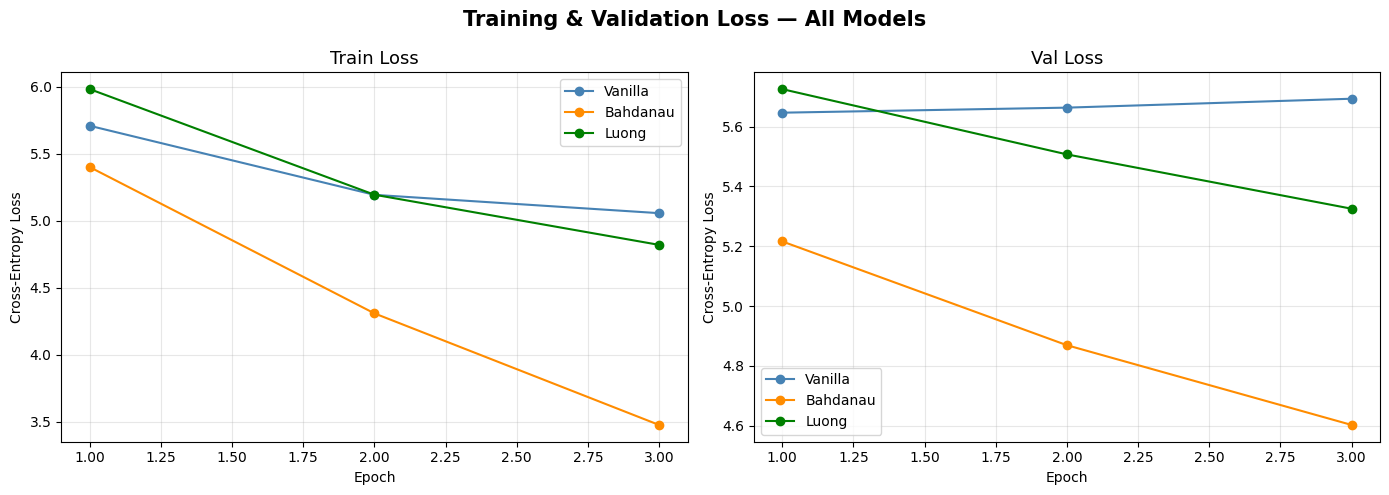

Plot saved as training_curves.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, EPOCHS + 1)
colors = ['steelblue', 'darkorange', 'green']
models_info = [
    ('Vanilla',   history_vanilla),
    ('Bahdanau',  history_bahdanau),
    ('Luong',     history_luong)
]

for ax_idx, split in enumerate(['train', 'val']):
    for (name, hist), c in zip(models_info, colors):
        axes[ax_idx].plot(epochs_range, hist[split], marker='o', color=c, label=name)
    axes[ax_idx].set_title(f'{split.capitalize()} Loss', fontsize=13)
    axes[ax_idx].set_xlabel('Epoch')
    axes[ax_idx].set_ylabel('Cross-Entropy Loss')
    axes[ax_idx].legend()
    axes[ax_idx].grid(alpha=0.3)

plt.suptitle('Training & Validation Loss — All Models', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()
print("Plot saved as training_curves.png")

## Cell 15: BLEU Score Evaluation

In [17]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, max_len=MAX_LEN):
    """Translate a single English sentence → Spanish tokens."""
    model.eval()
    tokens = normalize_string(sentence).split()
    idxs   = [src_vocab.word2idx.get(t, PAD_TOKEN) for t in tokens] + [EOS_TOKEN]
    src    = torch.tensor(idxs, dtype=torch.long).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        enc_out, hidden, cell = model.encoder(src)

    trg_idx   = [SOS_TOKEN]
    attn_store = []

    for _ in range(max_len):
        trg_tensor = torch.tensor([trg_idx[-1]], dtype=torch.long).to(DEVICE)
        with torch.no_grad():
            pred, hidden, cell, attn = model.decoder(trg_tensor, hidden, cell, enc_out)
        best = pred.argmax(dim=1).item()
        trg_idx.append(best)
        if attn is not None:
            attn_store.append(attn.squeeze(0).cpu().numpy())
        if best == EOS_TOKEN:
            break

    translation = [tgt_vocab.idx2word[i] for i in trg_idx[1:]
                   if i not in (EOS_TOKEN, PAD_TOKEN)]
    attn_matrix = np.array(attn_store) if attn_store else None
    return translation, attn_matrix, tokens


def compute_bleu(model, pairs, src_vocab, tgt_vocab):
    refs, hyps = [], []
    smooth = SmoothingFunction().method1
    for eng, spa in pairs:
        ref  = spa.split()
        hyp, _, _ = translate_sentence(model, eng, src_vocab, tgt_vocab)
        refs.append([ref])
        hyps.append(hyp)
    bleu = corpus_bleu(refs, hyps, smoothing_function=smooth)
    return bleu * 100

print("Computing BLEU scores (may take a moment)...")
bleu_vanilla  = compute_bleu(model_vanilla,  test_pairs, src_vocab, tgt_vocab)
bleu_bahdanau = compute_bleu(model_bahdanau, test_pairs, src_vocab, tgt_vocab)
bleu_luong    = compute_bleu(model_luong,    test_pairs, src_vocab, tgt_vocab)

print(f"\n{'Model':<20} {'BLEU Score':>10}")
print('-' * 32)
print(f"{'Vanilla Seq2Seq':<20} {bleu_vanilla:>9.2f}")
print(f"{'Bahdanau Attention':<20} {bleu_bahdanau:>9.2f}")
print(f"{'Luong Attention':<20} {bleu_luong:>9.2f}")

Computing BLEU scores (may take a moment)...

Model                BLEU Score
--------------------------------
Vanilla Seq2Seq           0.01
Bahdanau Attention        3.68
Luong Attention           0.27


## Cell 16: BLEU Comparison Bar Chart

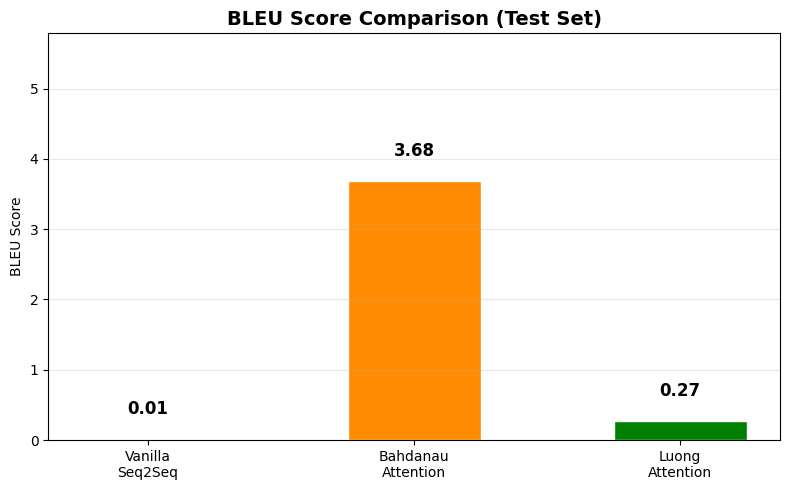

BLEU comparison chart saved.


In [18]:
model_names = ['Vanilla\nSeq2Seq', 'Bahdanau\nAttention', 'Luong\nAttention']
bleu_scores = [bleu_vanilla, bleu_bahdanau, bleu_luong]
bar_colors  = ['steelblue', 'darkorange', 'green']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(model_names, bleu_scores, color=bar_colors, edgecolor='white', width=0.5)

for bar, score in zip(bars, bleu_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f'{score:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title('BLEU Score Comparison (Test Set)', fontsize=14, fontweight='bold')
ax.set_ylabel('BLEU Score')
ax.set_ylim(0, max(bleu_scores) * 1.3 + 1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('bleu_comparison.png', dpi=150)
plt.show()
print("BLEU comparison chart saved.")

## Cell 17: Visualize Attention Weights — Bahdanau


=== Bahdanau Attention Visualizations ===

Example 1
  ENG : as far as i know i don t have any relatives in boston .
  SPA : que yo sepa no tengo familia en boston .
  PRED: no no tengo nada en boston en boston .


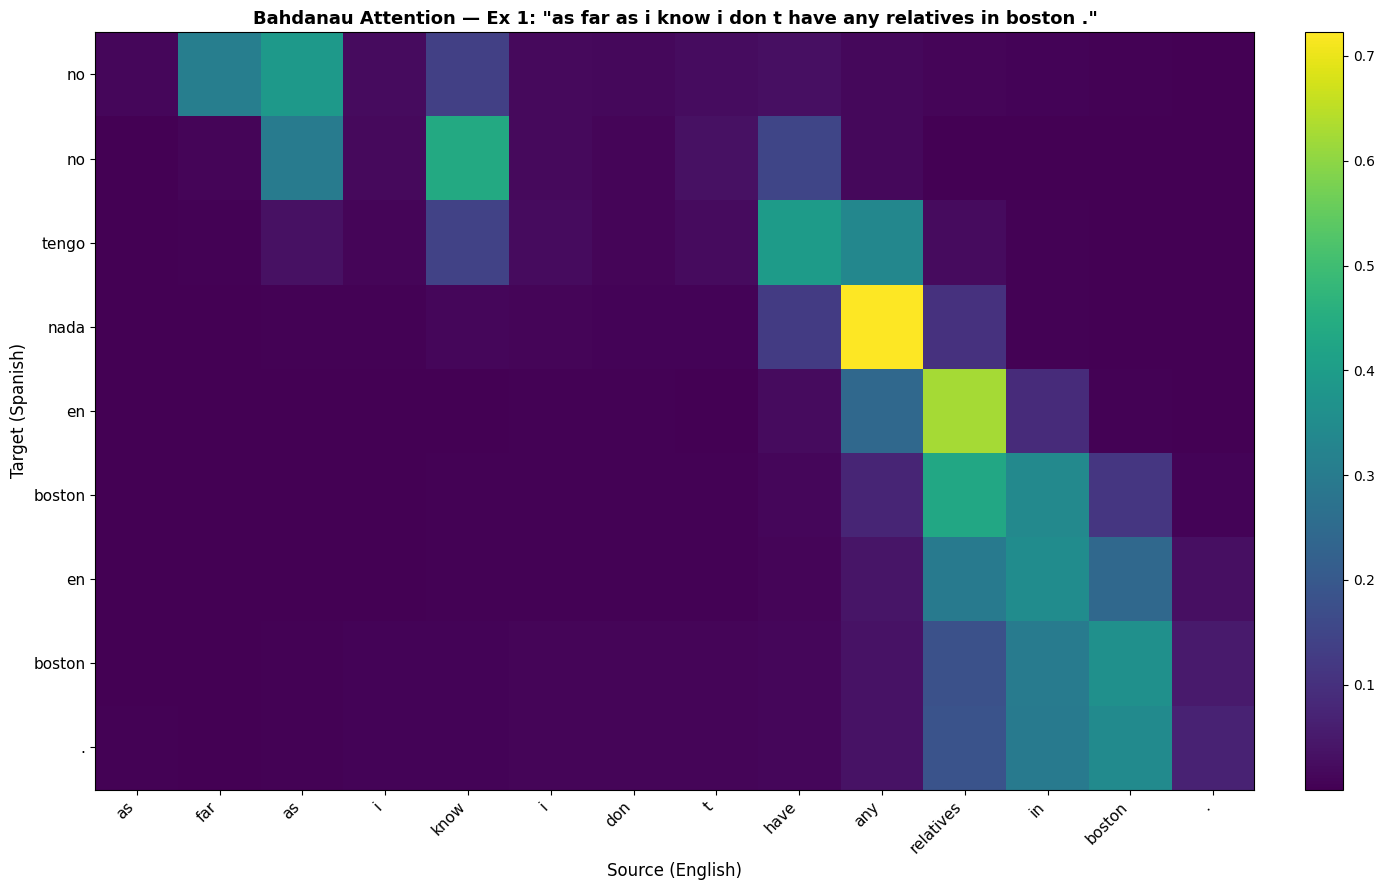

Saved: attn_bahdanau_1.png

Example 2
  ENG : do you have a table on the patio ?
  SPA : tienen una mesa en el patio ?
  PRED: un poco de la ?


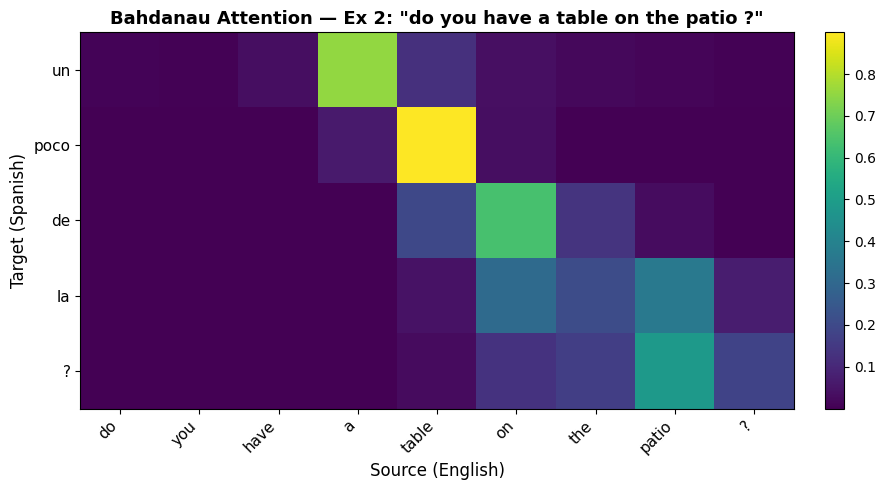

Saved: attn_bahdanau_2.png

Example 3
  ENG : don t you like wine ?
  SPA : no te gusta el vino ?
  PRED: gustan no ? ?


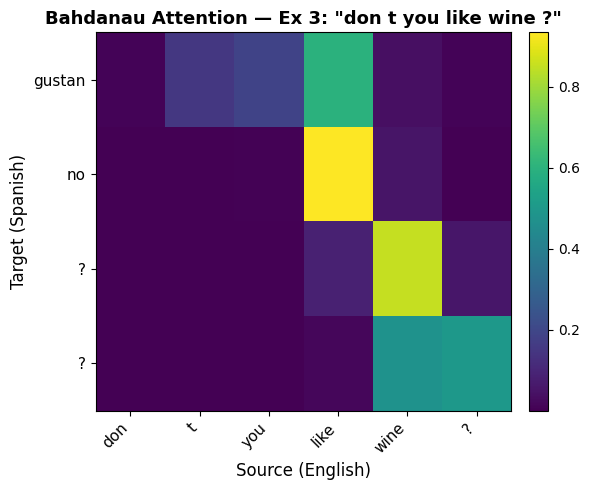

Saved: attn_bahdanau_3.png


In [19]:
def plot_attention(attn_matrix, src_tokens, tgt_tokens, title, filename):
    """Plot attention heatmap."""
    if attn_matrix is None or len(attn_matrix) == 0:
        print(f"No attention weights to visualize for '{title}'.")
        return

    # attn_matrix: (tgt_len, src_len)
    attn = attn_matrix[:len(tgt_tokens), :len(src_tokens)]

    fig, ax = plt.subplots(figsize=(max(6, len(src_tokens)), max(5, len(tgt_tokens))))
    im = ax.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha='right', fontsize=11)
    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_yticklabels(tgt_tokens, fontsize=11)
    ax.set_xlabel('Source (English)', fontsize=12)
    ax.set_ylabel('Target (Spanish)', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()
    print(f"Saved: {filename}")


# Pick 3 example sentences from test set
examples = test_pairs[:3]

print("\n=== Bahdanau Attention Visualizations ===")
for i, (eng, spa) in enumerate(examples):
    trans, attn_mat, src_tok = translate_sentence(model_bahdanau, eng, src_vocab, tgt_vocab)
    print(f"\nExample {i+1}")
    print(f"  ENG : {eng}")
    print(f"  SPA : {spa}")
    print(f"  PRED: {' '.join(trans)}")
    plot_attention(attn_mat, src_tok, trans,
                   title=f'Bahdanau Attention — Ex {i+1}: "{eng}"',
                   filename=f'attn_bahdanau_{i+1}.png')

## Cell 18: Visualize Attention Weights — Luong

=== Luong Attention Visualizations ===

Example 1
  ENG : as far as i know i don t have any relatives in boston .
  SPA : que yo sepa no tengo familia en boston .
  PRED: que que que que que que .


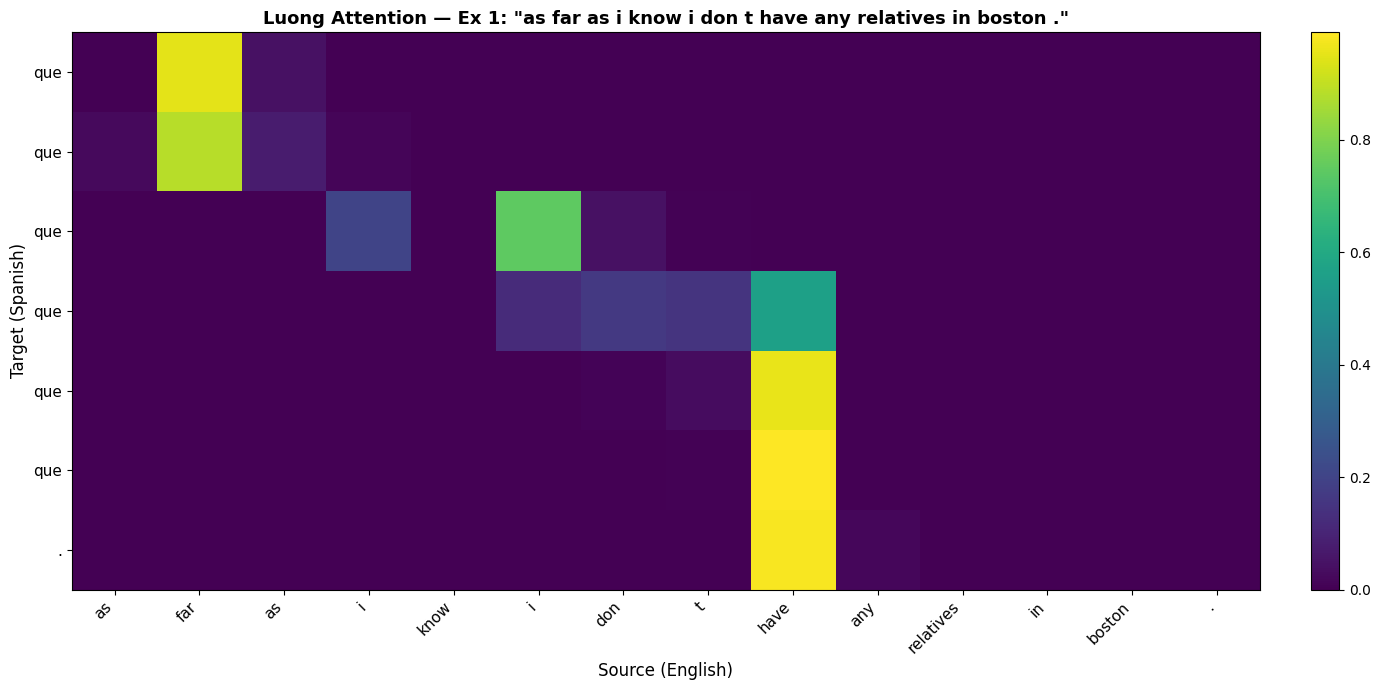

Saved: attn_luong_1.png

Example 2
  ENG : do you have a table on the patio ?
  SPA : tienen una mesa en el patio ?
  PRED: que un la de la ? ?


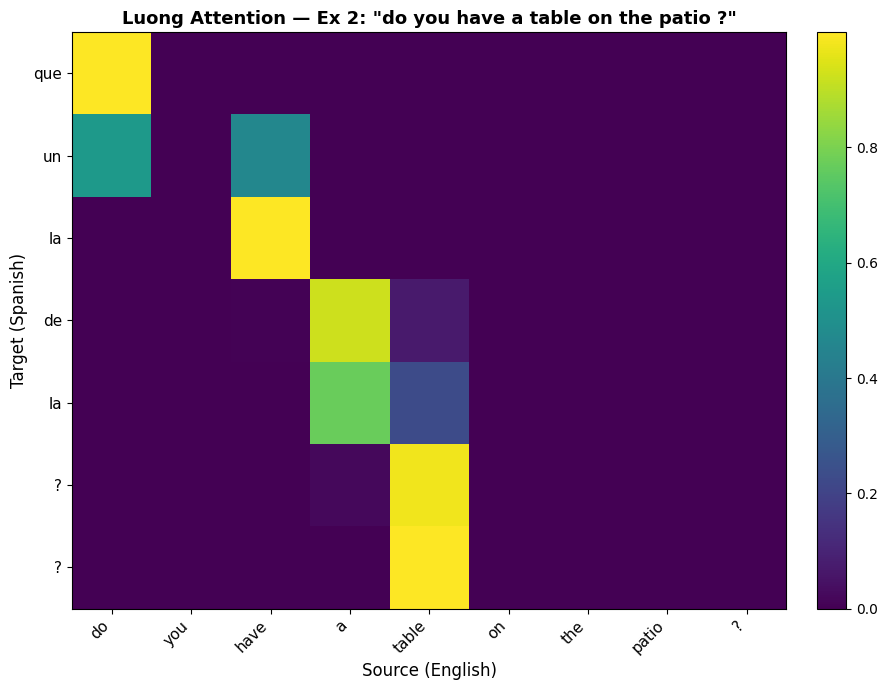

Saved: attn_luong_2.png

Example 3
  ENG : don t you like wine ?
  SPA : no te gusta el vino ?
  PRED: que que ? ?


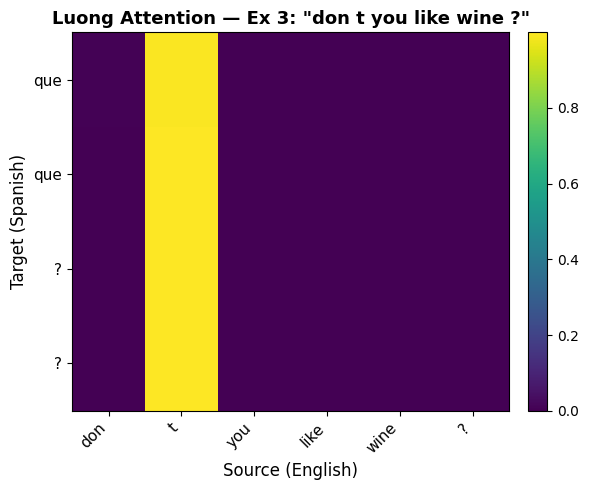

Saved: attn_luong_3.png


In [20]:
print("=== Luong Attention Visualizations ===")
for i, (eng, spa) in enumerate(examples):
    trans, attn_mat, src_tok = translate_sentence(model_luong, eng, src_vocab, tgt_vocab)
    print(f"\nExample {i+1}")
    print(f"  ENG : {eng}")
    print(f"  SPA : {spa}")
    print(f"  PRED: {' '.join(trans)}")
    plot_attention(attn_mat, src_tok, trans,
                   title=f'Luong Attention — Ex {i+1}: "{eng}"',
                   filename=f'attn_luong_{i+1}.png')

## Cell 19: Side-by-Side Translation Comparison

In [21]:
# Show 10 translations side-by-side from all three models
sample_sentences = [p[0] for p in test_pairs[:10]]
gold_refs        = [p[1] for p in test_pairs[:10]]

print(f"{'English':<30} | {'Gold Spanish':<25} | {'Vanilla':<20} | {'Bahdanau':<20} | {'Luong':<20}")
print('-' * 120)

for eng, ref in zip(sample_sentences, gold_refs):
    t_v, _, _ = translate_sentence(model_vanilla,  eng, src_vocab, tgt_vocab)
    t_b, _, _ = translate_sentence(model_bahdanau, eng, src_vocab, tgt_vocab)
    t_l, _, _ = translate_sentence(model_luong,    eng, src_vocab, tgt_vocab)
    print(f"{eng:<30} | {ref:<25} | {' '.join(t_v):<20} | {' '.join(t_b):<20} | {' '.join(t_l):<20}")

English                        | Gold Spanish              | Vanilla              | Bahdanau             | Luong               
------------------------------------------------------------------------------------------------------------------------
as far as i know i don t have any relatives in boston . | que yo sepa no tengo familia en boston . | que .                | no no tengo nada en boston en boston . | que que que que que que .
do you have a table on the patio ? | tienen una mesa en el patio ? | que .                | un poco de la ?      | que un la de la ? ? 
don t you like wine ?          | no te gusta el vino ?     | que .                | gustan no ? ?        | que que ? ?         
the policeman asked me why i was parked on the shoulder . | el policia me pregunto que por que estaba estacionado en el arcen . | que .                | me pregunto que me pregunto en el accidente . | que que que que la la .
tom had breakfast .            | tom desayuno .            | que .     

## Cell 20: Final Summary Table

In [22]:
print("\n" + "="*65)
print("         FINAL EXPERIMENT SUMMARY")
print("="*65)
print(f"Dataset    : ManyThings Tatoeba English-Spanish")
print(f"Pairs used : {len(pairs)} (filtered, max_len={MAX_LEN})")
print(f"Split      : 80% train / 10% val / 10% test")
print(f"Epochs     : {EPOCHS}")
print(f"Batch size : {BATCH_SIZE}")
print(f"Embed dim  : {EMBED_DIM} | Hidden dim: {HIDDEN_DIM} | Layers: {NUM_LAYERS}")
print("-"*65)
print(f"{'Model':<22} {'Train Loss':>11} {'Val Loss':>10} {'BLEU':>8}")
print("-"*65)

for name, hist, bleu in [
    ('Vanilla Seq2Seq',    history_vanilla,  bleu_vanilla),
    ('Bahdanau Attention', history_bahdanau, bleu_bahdanau),
    ('Luong Attention',    history_luong,    bleu_luong),
]:
    print(f"{name:<22} {hist['train'][-1]:>11.4f} {hist['val'][-1]:>10.4f} {bleu:>7.2f}")

print("="*65)
best = max([('Vanilla', bleu_vanilla), ('Bahdanau', bleu_bahdanau), ('Luong', bleu_luong)],
           key=lambda x: x[1])
print(f"\n  Best model: {best[0]} (BLEU = {best[1]:.2f})")
print("\n  Tip: Run for more epochs (10–20) and increase data")
print("  for significantly better translation quality.")
print("="*65)


         FINAL EXPERIMENT SUMMARY
Dataset    : ManyThings Tatoeba English-Spanish
Pairs used : 10000 (filtered, max_len=15)
Split      : 80% train / 10% val / 10% test
Epochs     : 3
Batch size : 64
Embed dim  : 256 | Hidden dim: 512 | Layers: 2
-----------------------------------------------------------------
Model                   Train Loss   Val Loss     BLEU
-----------------------------------------------------------------
Vanilla Seq2Seq             5.0560     5.6935    0.01
Bahdanau Attention          3.4748     4.6024    3.68
Luong Attention             4.8193     5.3256    0.27

  Best model: Bahdanau (BLEU = 3.68)

  Tip: Run for more epochs (10–20) and increase data
  for significantly better translation quality.


## Cell 21: (Bonus) Interactive Translation Demo

In [23]:
# Try your own sentence!
def demo_translate(sentence):
    print(f"\nInput   (ENG): {sentence}")
    for model, name in [(model_vanilla,  'Vanilla'),
                        (model_bahdanau, 'Bahdanau'),
                        (model_luong,    'Luong')]:
        trans, _, _ = translate_sentence(model, sentence, src_vocab, tgt_vocab)
        print(f"  {name:<10}: {' '.join(trans)}")

# Feel free to change these sentences
demo_translate("i am happy")
demo_translate("she speaks spanish")
demo_translate("he is my friend")


Input   (ENG): i am happy
  Vanilla   : que .
  Bahdanau  : soy .
  Luong     : . .

Input   (ENG): she speaks spanish
  Vanilla   : que .
  Bahdanau  : gustan las llaves .
  Luong     : a . .

Input   (ENG): he is my friend
  Vanilla   : que .
  Bahdanau  : es mi frances .
  Luong     : es el .
